In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")

from collections import Counter
import scanpy as sc

from functools import partial

In [2]:
adata = sc.read_h5ad('Monocyte CD14-2.h5ad')

In [3]:
adata.obs['subsets'] = pd.Categorical(adata.obs['new_subset_annotations_2'].map({
    'Monocyte CD14': 'CD14 ISG Low',
    'Monocyte CD14 ISG 1': 'CD14 ISG High',
    'Monocyte CD14 ISG 2': 'CD14 ISG High',
    'Monocyte CD14 ISG (Low)': 'CD14 ISG Dim',
    'Monocyte CD14 ISG Inflamm.': 'CD14 ISG High',
}),  categories=['CD14 ISG Low', 'CD14 ISG Dim', 'CD14 ISG High'])

In [4]:
# adata.obs['Vaccine_Visit'] = utils.make_combined_column(adata, ['Vaccine', 'Visit'])

In [5]:
adata.obs['subset_vax'] = utils.make_combined_column(adata, ['subsets', 'Vaccine'])
adata.obs['subset_vax'] = pd.Categorical(adata.obs['subset_vax'], categories=['CD14 ISG High J&J', 'CD14 ISG High Moderna', 'CD14 ISG High Pfizer',
                                            'CD14 ISG Dim J&J', 'CD14 ISG Dim Moderna', 'CD14 ISG Dim Pfizer',
                                                 'CD14 ISG Low J&J', 'CD14 ISG Low Moderna', 'CD14 ISG Low Pfizer']
                                          )

In [6]:
inf_genes = GeneModules.InterferonModules.Damiens.all_combined_2021();
inf_genes = [gene for gene in inf_genes if gene in adata.raw.var_names]

adata.obs['IFN Score'] = sc.get.obs_df(adata, inf_genes, use_raw=True).mean(axis = 1)

In [7]:
adata = adata[adata.obs['Vaccine'] != 'J&J'].copy()

In [8]:
adata.obs['Vaccine'] = adata.obs['Vaccine'].cat.remove_unused_categories()

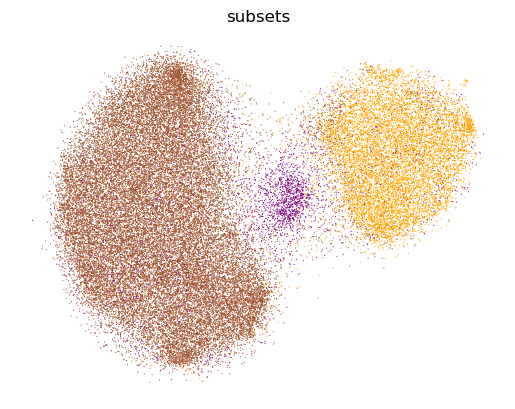

In [10]:

palette = {'CD14 ISG Low': 'sienna', 'CD14 ISG Dim': 'purple', 'CD14 ISG High': 'orange'}
fig = sc.pl.embedding(adata, color = 'subsets', palette=palette, show=False, frameon=False, legend_loc=None, colorbar_loc=None, return_fig=True, basis=f'X_tsne_{15}_{800}')


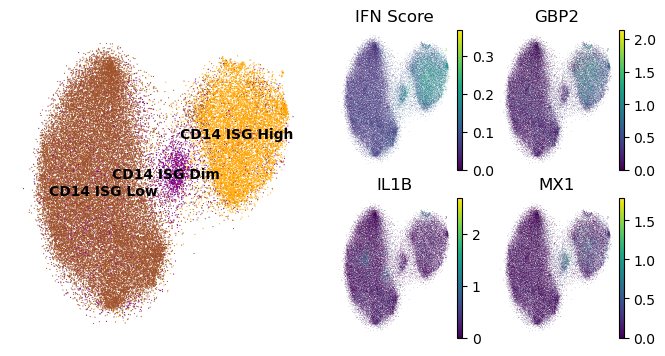

In [11]:
fig, axs = plt.subplot_mosaic(
    """
    AABD
    AACE
    """, 
    figsize = (8, 4),
    dpi = 100
)
sc.pl.embedding(adata, color = ['subsets'], show=False, frameon=False, legend_loc = 'on data', basis=f'X_tsne_{15}_{800}', ax=axs['A'])
ax=axs['A'].set_title(None)

for panel, feature in zip('BCDE', ['IFN Score', 'IL1B', 'GBP2', 'MX1', 'MX2']):
    sc.pl.embedding(adata, color = feature, show=False, frameon=False, legend_loc=None, ax=axs[panel], basis=f'X_tsne_{15}_{800}', size = 0.4)

# my_plotting.savefig_png_eps(fig, 'monocyte_cd14_featureplots', make_folder=True)

In [12]:
adata_vc = utils.clean_visits(adata)

In [ ]:
df = adata_vc.obs.loc[adata_vc.obs['subsets'] == 'CD14 ISG Dim', ['person', 'Visit']].value_counts()
df = 100*df/adata_vc.obs[['person', 'Visit']].value_counts()
df = df.reindex(index_mRNA, fill_value=0)
df = df.reset_index().rename(columns={'count' : 'Percentages'})
df.head()

In [15]:
def cell_proportions_longitudinal_box_plot_2(pbmc_vc, celltype_name, annots_col, figsize = (4, 4), color = None, title = ''):
    df = pbmc_vc.obs.loc[pbmc_vc.obs[annots_col] == celltype_name, ['person', 'Visit']].value_counts()
    df = 100*df/pbmc_vc.obs[['person', 'Visit']].value_counts()
    df = df.reindex(index_mRNA, fill_value=0)
    df = df.reset_index()
    df['Visit'] = pd.Categorical(df['Visit'], categories = pbmc_vc.obs['Visit'].cat.categories)

    fig, ax = plt.subplots(figsize = figsize)
    y_max = df['count'].max()
    y_min = df['count'].min()
    df['vax'] = df['person'].map(covax_constants.donor_to_vax_dict)

    # df = df.sort_values(by = 'person')
    sns.boxplot(df, x='Visit', y='count', fill=True, color = color, showfliers=False, dodge=False, width=0.7, saturation = 1, ax = ax)
    strip = sns.stripplot(df, x='Visit', y='count', jitter=True, size=6, legend=True, ax=ax, hue = 'vax', dodge=True, palette=covax_constants.vax_colors)

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(y_min*0.90, y_max*1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, color = color, fontsize= 18)
        
    ax.set_ylabel('Cell Percentages')
    ax.set_xlabel('')

    ax.get_legend().remove()
        
    fig.suptitle(f'{celltype_name} Percentages Per Donor/Visit', fontsize = 12);
    return fig

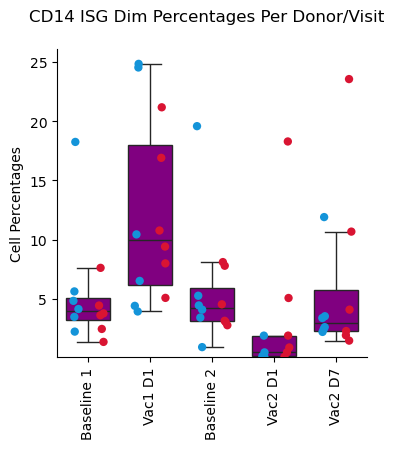

In [16]:
fig = cell_proportions_longitudinal_box_plot_2(adata_vc, 'CD14 ISG Dim', 'subsets', color = palette['CD14 ISG Dim']);
# my_plotting.savefig_png_eps(fig, 'cd14_isg_dim_perc_long_plot', make_folder=True, use_timestamp=False)

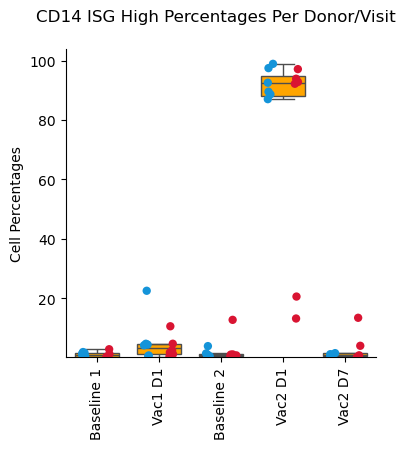

In [161]:
fig = cell_proportions_longitudinal_box_plot_2(adata_vc, 'CD14 ISG High', 'subsets', color = palette['CD14 ISG High']);
# my_plotting.savefig_png_eps(fig, 'cd14_isg_high_perc_long_plot', make_folder=True, use_timestamp=False)